In [1]:
%matplotlib inline
# !pip install pennylane
import time
seconds = time.time()
print("Time in seconds since beginning of run:", seconds)
local_time = time.ctime(seconds)
print(local_time)

Time in seconds since beginning of run: 1726857375.045664
Fri Sep 20 11:36:15 2024


In [42]:
%pip install PennyLane-Lightning-GPU

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: Loading egg at /global/common/software/nersc9/pytorch/2.3.1/lib/python3.11/site-packages/torchvision-0.18.0a0+6043bc2-py3.11-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 9.8 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
from pennylane import broadcast
import torch
from torch.utils.data import DataLoader, TensorDataset


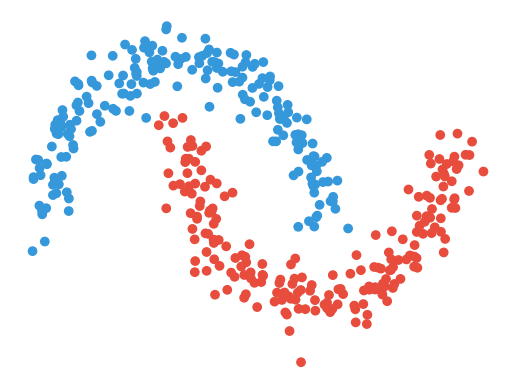

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.datasets import make_moons

# Set random seeds
torch.manual_seed(149)
np.random.seed(149)

X, y = make_moons(n_samples=400, noise=0.1)
y_ = torch.unsqueeze(torch.tensor(y), 1)  # used for one-hot encoded labels
y_hot = torch.scatter(torch.zeros((400, 2)), 1, y_, 1)

# Adjusted color scheme for better contrast
c = ["#3498db" if y_ == 0 else "#e74c3c" for y_ in y]  # New colors for each class
plt.axis("off")
plt.scatter(X[:, 0], X[:, 1], c=c)
plt.show()


In [4]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)

In [54]:
import pennylane as qml
from pennylane import numpy as np

# Define a quantum device
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

# Define a quantum node (qnode)
@qml.qnode(dev)
def circuit(weights):
    # Apply Hadamard gate to all qubits
    for i in range(n_qubits):
        qml.Hadamard(wires=i)

    # Apply a barrier here
    qml.Barrier(wires=range(n_qubits))

    # Apply a layer of parameterized rotations
    for i in range(n_qubits):
        qml.RY(weights[i], wires=i)
    
    # Another barrier
    qml.Barrier(wires=range(n_qubits))

    # Entangling layer with CNOT gates
    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i + 1])

    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Define some weights for the parameterized rotations
weights = np.random.random(n_qubits)

# Execute the circuit
result = circuit(weights)

# Print the result
print(result)
print(qml.draw(circuit)(weights))

[tensor(-0.05111985, requires_grad=True), tensor(0.02091595, requires_grad=True), tensor(-0.01665866, requires_grad=True), tensor(0.01085561, requires_grad=True)]
0: ──H─╭||──RY(0.05)─╭||─╭●───────┤  <Z>
1: ──H─├||──RY(0.42)─├||─╰X─╭●────┤  <Z>
2: ──H─├||──RY(0.92)─├||────╰X─╭●─┤  <Z>
3: ──H─╰||──RY(0.71)─╰||───────╰X─┤  <Z>


In [67]:
import pennylane as qml
import numpy as np

n_qubits = 10
n_layers = 1  # Example number of layers
dev = qml.device("lightning.qubit", wires=n_qubits)

# Define the Hadamard layer
def H_layer(n_qubits):
    for i in range(n_qubits):
        qml.Hadamard(wires=i)

# Define a custom function to add arbitrary rotations
def custom_rot_layer(weights, wires):
    # Apply Rot (arbitrary rotation) to each qubit individually
    for i, wire in enumerate(wires):
        phi, theta, omega = weights[i]
        qml.Rot(phi, theta, omega, wires=wire)

# Define a custom function for entanglement
def entangling_layer(wires, measured_1, measured_2):
    for j in range(len(wires) - 1):
        # Apply CNOT unconditionally between adjacent qubits
        qml.CNOT(wires=[wires[j], wires[j + 1]])

        # Conditionally apply CRZ if measured_1 is 1 (control qubit on qubit 1)
        qml.cond(measured_1, qml.CRZ)(np.pi / 2, wires=[wires[j], wires[j + 1]])

        # Conditionally apply a controlled-RY gate if measured_2 is 1 (control qubit on qubit 2)
        qml.cond(measured_2, qml.CRY)(np.pi / 4, wires=[wires[j], wires[j + 1]])

@qml.qnode(dev)
def qnode(inputs, weights, x, z):
    H_layer(n_qubits)

    for i in range(n_layers):
        # Embedding with alternating rotation axes
        if i % 2 == 0:
            qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Y')
        else:
            qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Z')
        
        # Measure qubits 1 and 2 for conditional execution
        measured_1 = qml.measure(1)
        measured_2 = qml.measure(2)

        # Add an entangling layer with partial conditional gates
        entangling_layer(range(n_qubits), measured_1, measured_2)
        
        # Apply a custom layer of arbitrary rotations using qml.Rot
        custom_rot_layer(weights[i], range(n_qubits))

    # Apply a final set of Rot gates to close the circuit
    custom_rot_layer(weights[-1], range(n_qubits))
    
    # Apply a controlled CRZ rotation based on the measurement of qubit 2
    qml.cond(measured_2, qml.CRZ)(z, wires=(3, 0))

    # Final Hadamard layer
    H_layer(n_qubits)

    # Return PauliZ expectation values and the measurement probabilities for qubit 2
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)], qml.probs(op=measured_2)


In [73]:
@qml.qnode(dev)
def qnode(inputs, weights, x, z):
    H_layer(n_qubits)
    qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Y')
    # Final Hadamard layer
    H_layer(n_qubits)

    # Return PauliZ expectation values and the measurement probabilities for qubit 2
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

In [31]:
core_node_cut = core_node[:-23]

NameError: name 'core_node' is not defined

In [32]:
import pennylane as qml

n_qubits = 10
dev = qml.device("lightning.qubit", wires=n_qubits)
core_node = qml.from_qasm(core_node_cut) 
@qml.qnode(dev)
def qnode(inputs, weights):
    H_layer(n_qubits)
    for i in range(n_layers//2):
        qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Y')
        qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Z')
        qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Y')
    H_layer(n_qubits)
    # core_node(wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

NameError: name 'core_node_cut' is not defined

In [33]:
n_layers = 5
weight_shapes = {"weights": (n_layers, n_qubits)}

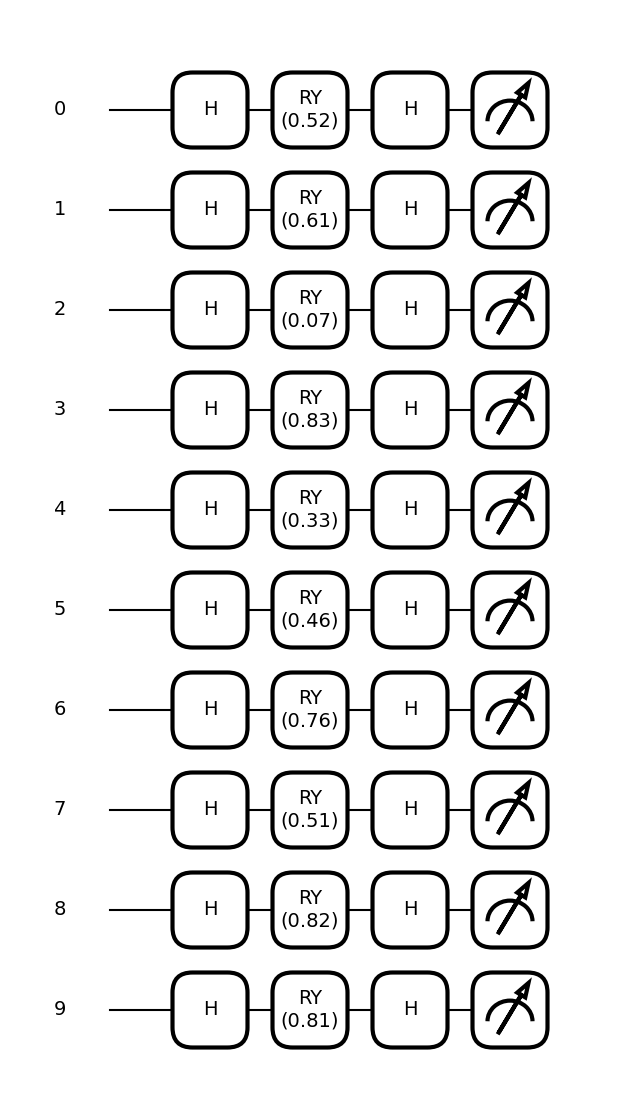

In [74]:
# Example inputs and weights
inputs = np.random.rand(n_qubits)
weights = np.random.rand(n_layers + 1, n_qubits, 3)  # +1 for the final Rot layer
x = np.pi / 6  # Example parameter for RX
z = np.pi / 4  # Example parameter for CRZ

fig, ax = qml.draw_mpl(qnode, show_all_wires=True, decimals=2, level="device")(inputs,weights,x,z)
fig.show()

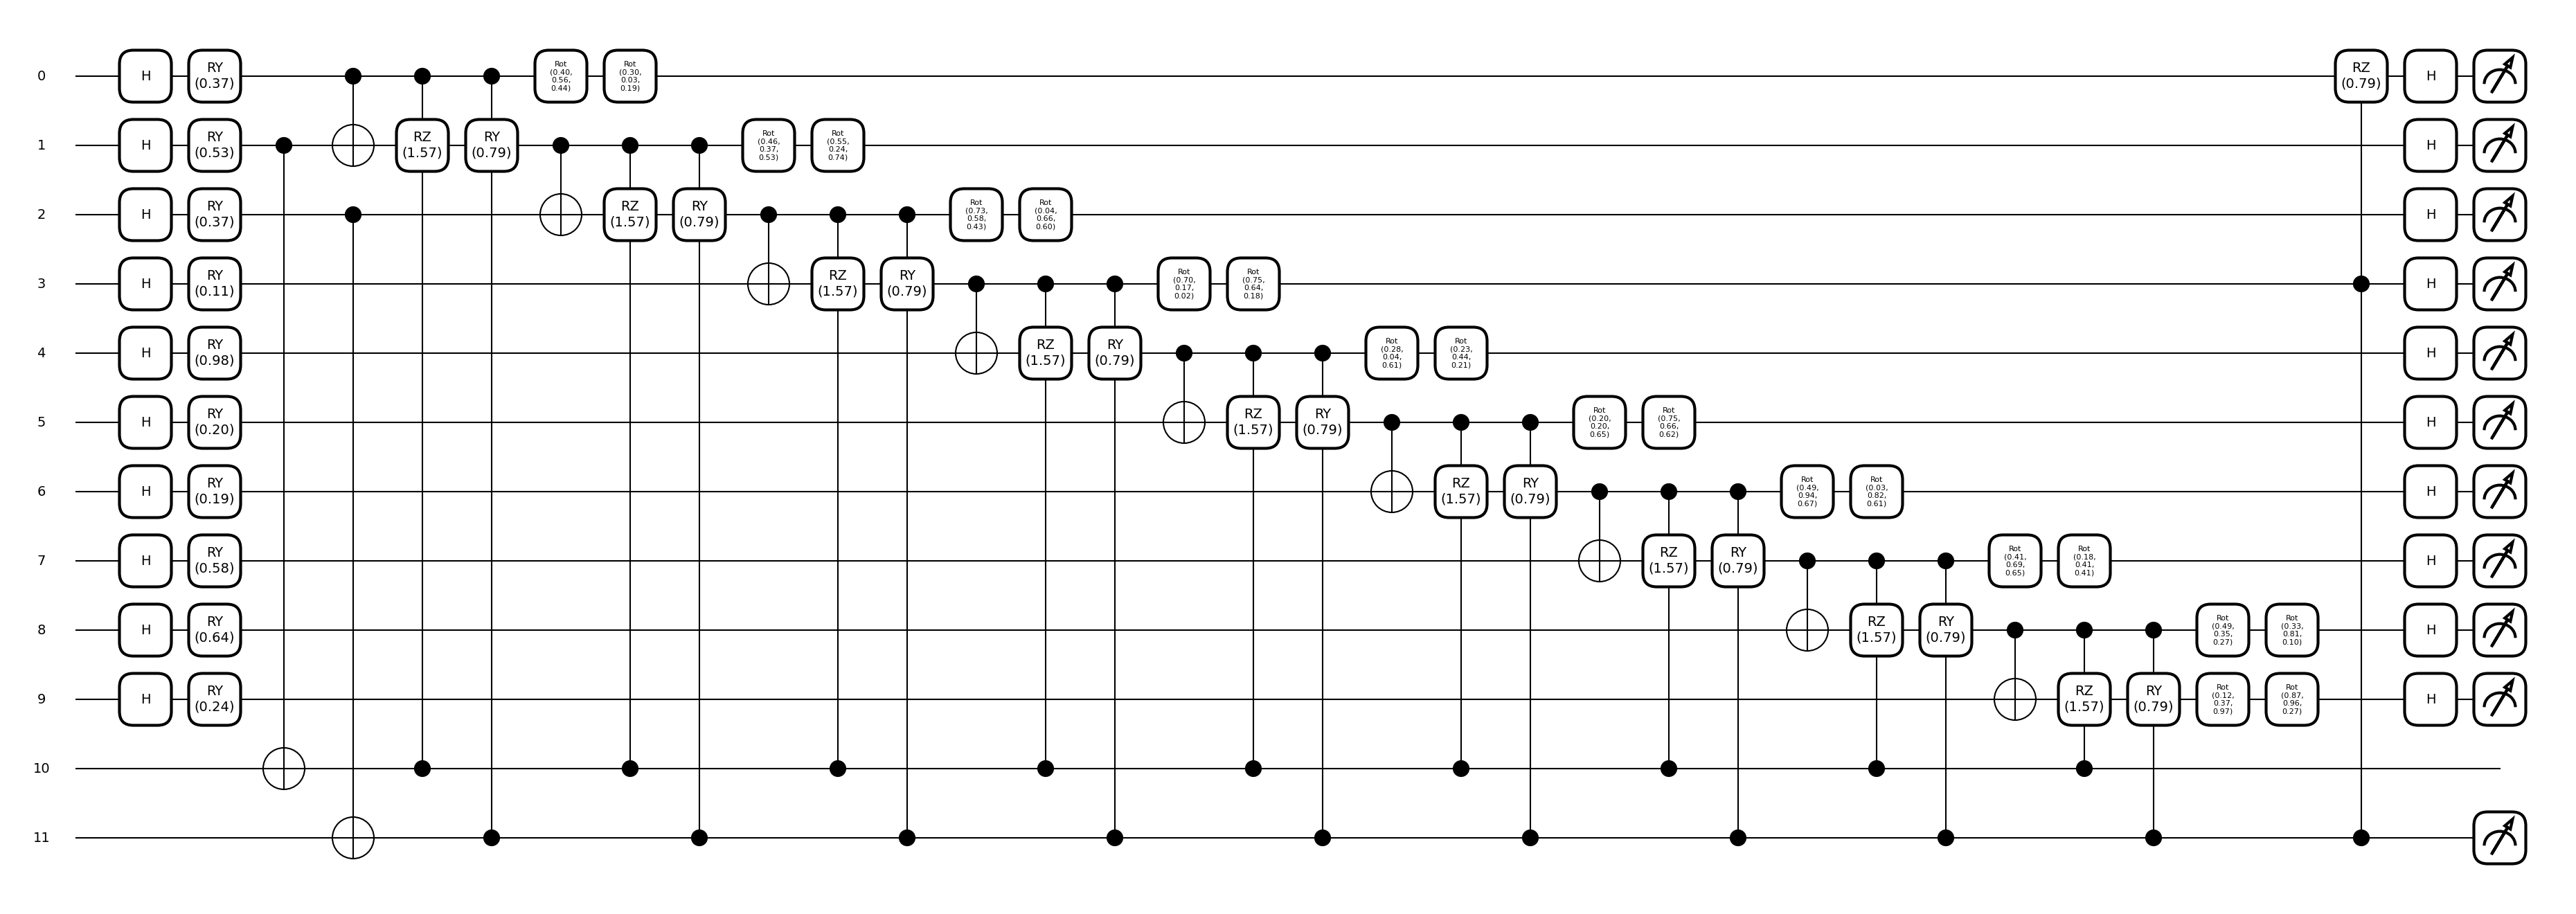

In [69]:
# Example inputs and weights
inputs = np.random.rand(n_qubits)
weights = np.random.rand(n_layers + 1, n_qubits, 3)  # +1 for the final Rot layer
x = np.pi / 6  # Example parameter for RX
z = np.pi / 4  # Example parameter for CRZ

fig, ax = qml.draw_mpl(qnode, show_all_wires=True, decimals=2, level="device")(inputs,weights,x,z)
fig.show()

/tmp/ipykernel_937227/3400799527.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


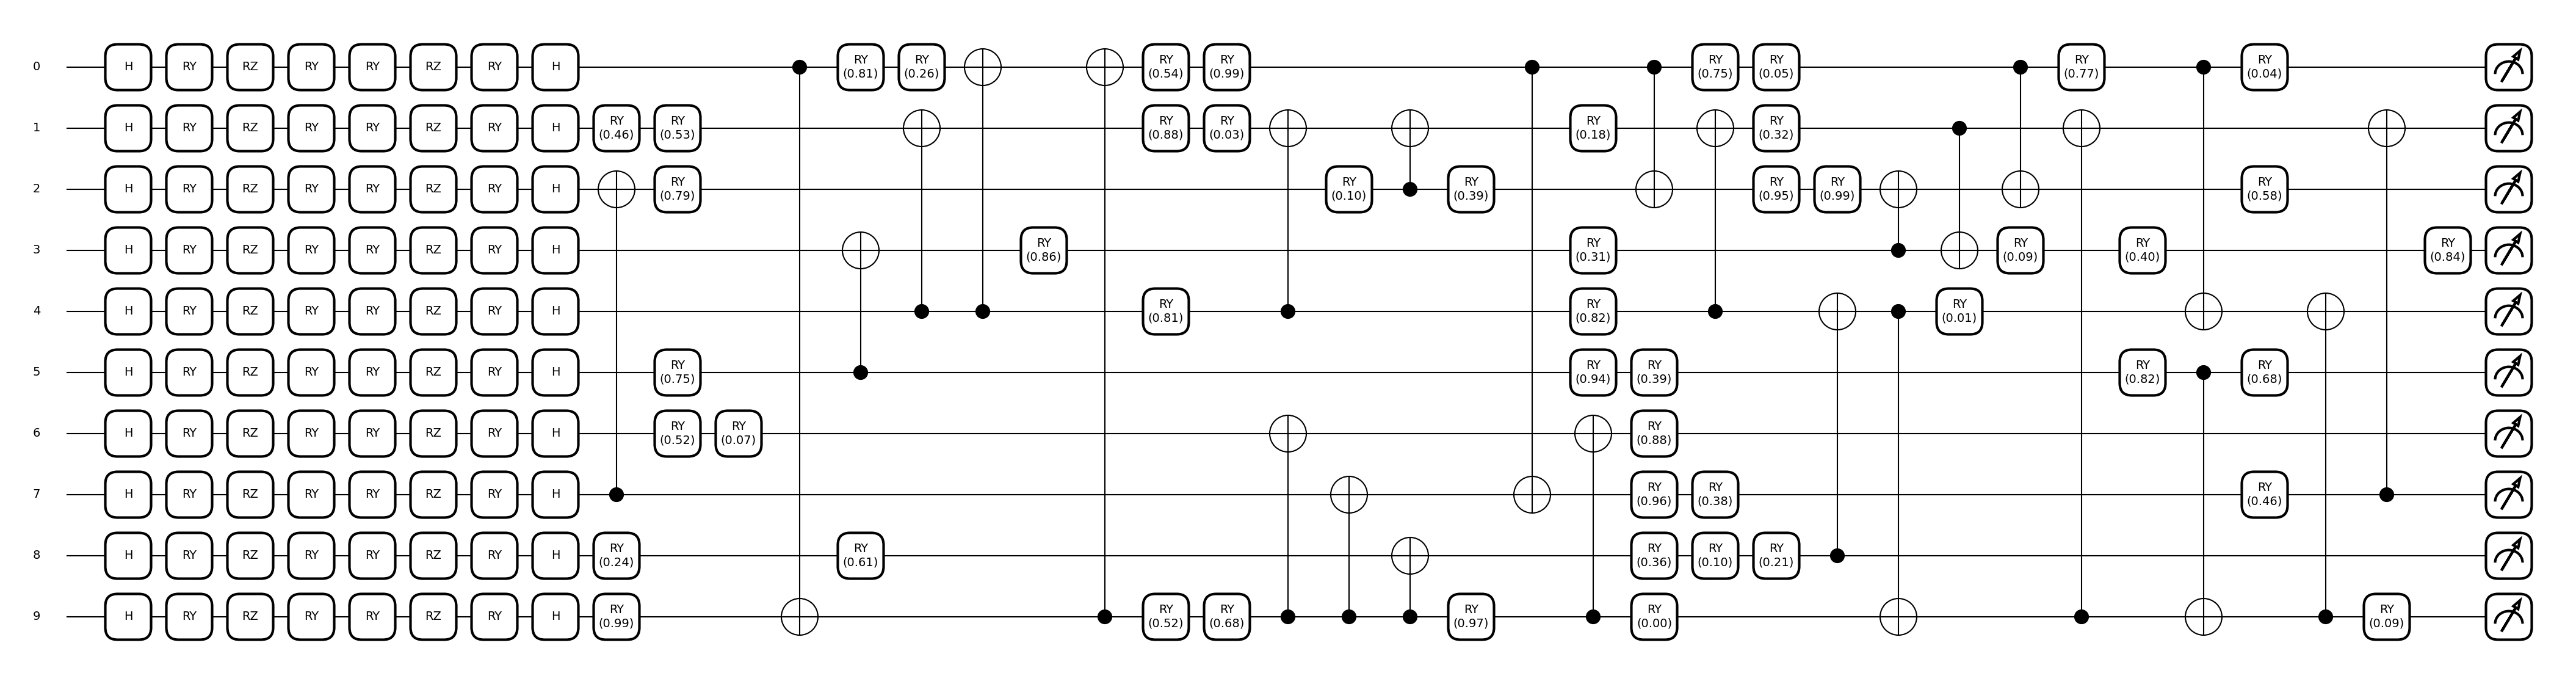

In [44]:
w = np.random.random(size=(n_layers, n_qubits))
fig, ax = qml.draw_mpl(qnode, show_all_wires=True, decimals=2, expansion_strategy="device")(w,w)
fig.show()

In [70]:
fig.savefig("structure2.png")

In [28]:
print(qml.draw(qnode, expansion_strategy="device")(w,w))

0: ──H──RY(M0)──RZ(M0)──RY(M0)──RY(M0)──RZ(M0)──RY(M0)──H──RY(0.24)──RZ(0.84)────────────────────
1: ──H──RY(M1)──RZ(M1)──RY(M1)──RY(M1)──RZ(M1)──RY(M1)──H──RY(0.20)──RZ(0.26)──RX(0.37)──RY(0.91)
2: ──H──RY(M2)──RZ(M2)──RY(M2)──RY(M2)──RZ(M2)──RY(M2)──H──RZ(0.44)──RX(0.78)──RZ(0.47)──RY(0.24)
3: ──H──RY(M3)──RZ(M3)──RY(M3)──RY(M3)──RZ(M3)──RY(M3)──H──RX(0.21)──RX(0.15)──RZ(0.43)──RX(0.29)
4: ──H──RY(M4)──RZ(M4)──RY(M4)──RY(M4)──RZ(M4)──RY(M4)──H──RY(0.41)──RZ(0.69)──RX(0.46)──RX(0.82)
5: ──H──RY(M5)──RZ(M5)──RY(M5)──RY(M5)──RZ(M5)──RY(M5)──H──RY(0.24)──RY(0.47)──RX(0.42)──RZ(0.35)
6: ──H──RY(M6)──RZ(M6)──RY(M6)──RY(M6)──RZ(M6)──RY(M6)──H──RY(0.66)──────────────────────────────
7: ──H──RY(M7)──RZ(M7)──RY(M7)──RY(M7)──RZ(M7)──RY(M7)──H──RZ(0.26)──RZ(0.94)──RY(0.23)──RZ(0.09)
8: ──H──RY(M8)──RZ(M8)──RY(M8)──RY(M8)──RZ(M8)──RY(M8)──H──RX(0.69)──RZ(0.26)──RY(0.98)──RZ(0.16)
9: ──H──RY(M9)──RZ(M9)──RY(M9)──RY(M9)──RZ(M9)──RY(M9)──H──RZ(0.18)──RX(0.48)──RZ(0.78)──RX(0.23)

───────────────────

In [20]:
loss_func = torch.nn.L1Loss()

In [21]:
class HybridModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.clayer_1 = torch.nn.Linear(2, 20)
        self.qlayer_1 = qml.qnn.TorchLayer(qnode, weight_shapes)
        self.qlayer_2 = qml.qnn.TorchLayer(qnode, weight_shapes)
        self.clayer_2 = torch.nn.Linear(20, 2)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.clayer_1(x)
        x_1, x_2 = torch.split(x, 10, dim=1)
        x_1 = self.qlayer_1(x_1)
        x_2 = self.qlayer_2(x_2)
        x = torch.cat([x_1, x_2], axis=1)
        x = self.clayer_2(x)
        return self.softmax(x)

model = HybridModel()

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
X = torch.tensor(X, requires_grad=True).float()
y_hot = y_hot.float()

batch_size = 5
batches = 200 // batch_size

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=149)
# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, requires_grad=True).float()
y_ = torch.unsqueeze(torch.tensor(y_train), 1)  # used for one-hot encoded labels
y_train_hot = torch.scatter(torch.zeros((280, 2)), 1, y_, 1)
y_train_hot = y_train_hot.float()

X_test = torch.tensor(X_test, requires_grad=True).float()
y_ = torch.unsqueeze(torch.tensor(y_test), 1)  # used for one-hot encoded labels
y_test_hot = torch.scatter(torch.zeros((120, 2)), 1, y_, 1)
y_test_hot = y_test_hot.float()

train_dataset = TensorDataset(X_train, y_train_hot)
test_dataset = TensorDataset(X_test, y_test_hot)

train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=True, drop_last=True)

opt = torch.optim.SGD(model.parameters(), lr=0.52)

train_acc_history = []
test_acc_history = []

epochs = 40

for epoch in range(epochs):
    train_running_loss = 0
    test_running_loss = 0
    for xs, ys in train_loader:
        opt.zero_grad()

        loss_evaluated = loss_func(model(xs), ys)
        loss_evaluated.backward()

        opt.step()

        train_running_loss += loss_evaluated.item()
        
    train_avg_loss = train_running_loss / batches

    print(f"Train - Epoch {epoch + 1}: Loss: {train_avg_loss:.4f}")

    # Calculate train accuracy
    y_pred_train = model(X_train)
    predictions_train = torch.argmax(y_pred_train, axis=1).detach().numpy()

    correct_train = [1 if p == p_true else 0 for p, p_true in zip(predictions_train, y_train)]
    train_accuracy = sum(correct_train) / len(correct_train)
    print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
    train_acc_history.append(train_accuracy)
    
    # Calculate testmodel.eval()
    with torch.no_grad():
        y_pred_test = model(X_test)
        predictions_test = torch.argmax(y_pred_test, axis=1).detach().numpy()
        correct_test = [1 if p == p_true else 0 for p, p_true in zip(predictions_test, y_test)]
        test_accuracy = sum(correct_test) / len(correct_test)
        print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
        test_acc_history.append(test_accuracy)
    

/tmp/ipykernel_2121533/1585914263.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, requires_grad=True).float()
/tmp/ipykernel_2121533/1585914263.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, requires_grad=True).float()


Train - Epoch 1: Loss: 0.1410
Train Accuracy: 98.57%
Test Accuracy: 98.33%
Train - Epoch 2: Loss: 0.0278
Train Accuracy: 99.29%
Test Accuracy: 100.00%
Train - Epoch 3: Loss: 0.0276
Train Accuracy: 98.93%
Test Accuracy: 99.17%
Train - Epoch 4: Loss: 0.0360
Train Accuracy: 98.93%
Test Accuracy: 99.17%
Train - Epoch 5: Loss: 0.0208
Train Accuracy: 98.93%
Test Accuracy: 99.17%
Train - Epoch 6: Loss: 0.0304
Train Accuracy: 98.93%
Test Accuracy: 99.17%
Train - Epoch 7: Loss: 0.0218
Train Accuracy: 99.29%
Test Accuracy: 100.00%
Train - Epoch 8: Loss: 0.0189
Train Accuracy: 99.64%
Test Accuracy: 98.33%
Train - Epoch 9: Loss: 0.0213
Train Accuracy: 99.64%
Test Accuracy: 100.00%
Train - Epoch 10: Loss: 0.0104
Train Accuracy: 98.93%
Test Accuracy: 99.17%
Train - Epoch 11: Loss: 0.0104
Train Accuracy: 100.00%
Test Accuracy: 100.00%
Train - Epoch 12: Loss: 0.0194
Train Accuracy: 98.93%
Test Accuracy: 100.00%
Train - Epoch 13: Loss: 0.0234
Train Accuracy: 95.36%
Test Accuracy: 96.67%
Train - Epoch 1

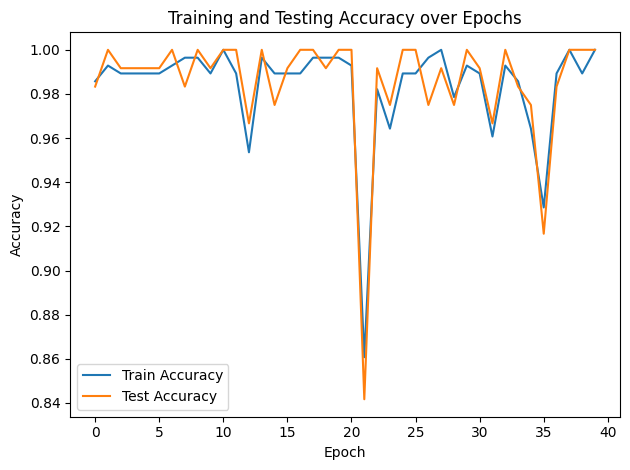

In [24]:
# Plotting the training and testing accuracies
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(test_acc_history, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Testing Accuracy over Epochs')
plt.tight_layout()
plt.show()

In [41]:
# Generate mesh grid covering the feature space
# Creating a meshgrid
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

In [42]:
mesh_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

In [47]:
Z = predictions_train.reshape(xx.shape)

ValueError: cannot reshape array of size 280 into shape (310,429)

In [37]:
# Predict class for each point in the grid
Z = predictions_train.reshape(xx.shape)

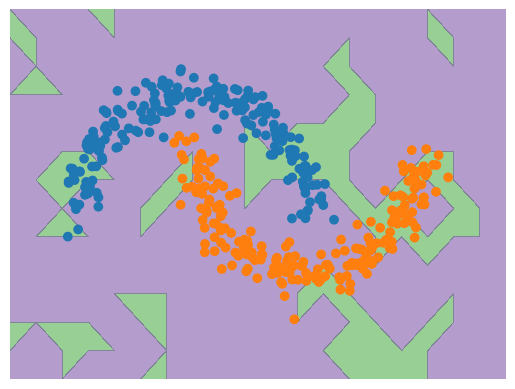

In [38]:
# Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.5, levels=np.arange(-1, 2), cmap=plt.cm.Paired, zorder=-1)

# Overlay the original dataset
c = ["#1f77b4" if y_ == 0 else "#ff7f0e" for y_ in y]  # Colours for each class
plt.scatter(X[:, 0], X[:, 1], c=c, zorder=0)

plt.axis("off")
plt.show()

In [9]:
seconds = time.time()
print("Time in seconds since end of run:", seconds)
local_time = time.ctime(seconds)
print(local_time)

Time in seconds since end of run: 1708813854.662059
Sat Feb 24 15:30:54 2024
